In [20]:
import pandas as pd
import numpy as np
import sys, os
from importlib import reload

# Append path for testing - use pyproject for the future
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
import analysis_functions as f
reload(f)

from create_tabulation import generate_tabulations, generate_and_save_tabulations

In [4]:
df = pd.read_csv("../data/bank-full.csv", delimiter=';')

In [5]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [26]:
# Convert 'y' to numeric for analysis
df["target"] = np.where(df["y"] == "no", 0, 1)

# Add weights to test weight functionality of plot_target_vs_predictors()
df["weights"] = np.abs(np.random.randn(len(df.index)))

# Add an arbitrary data split for testing functions
df["random"] = np.random.uniform(0, 1, len(df.index))
df["split"] = np.where(df["random"]  > 0.70, "V", "T")

In [28]:
df["split"].value_counts(dropna=False, normalize=True)

T    0.697972
V    0.302028
Name: split, dtype: float64

In [29]:
df.groupby("split")["target"].mean()

split
T    0.116238
V    0.118711
Name: target, dtype: float64

### Add GLM and GBM predictions for testing functions

In [30]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [31]:
# Split data; define features and target
X = df.drop(columns=["y", "split", "target"])
X_train = df.query("split == 'T'").drop(columns=["y", "split", "target"])
X_test = df.query("split == 'V'").drop(columns=["y", "split", "target"])
y_train = df.query("split == 'T'")["target"]
y_test = df.query("split == 'V'")["target"]

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numerical_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# GLM model
glm_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(solver='liblinear'))
])
glm_pipeline.fit(X_train, y_train)
df["pred_glm"] = glm_pipeline.predict_proba(X)[:, 1]

# XGBoost model
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(use_label_encoder=False, eval_metric='logloss'))
])
xgb_pipeline.fit(X_train, y_train)
df["pred_xgb"] = xgb_pipeline.predict_proba(X)[:, 1]


c:\Users\asacco\AppData\Local\anaconda3\envs\tier\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [32]:
df[["pred_glm", "pred_xgb", "target"]].describe()

,pred_glm,pred_xgb,target
count,45211.000000,4.521100e+04,45211.000000
mean,0.114883,1.142456e-01,0.116985
std,0.185928,2.287123e-01,0.321406
min,0.000016,5.424782e-07,0.000000
25%,0.015645,9.846428e-04,0.000000
50%,0.038044,7.524079e-03,0.000000
75%,0.112446,7.687871e-02,0.000000
max,1.000000,9.902917e-01,1.000000


## plot_target_vs_predictors function

In [33]:
predictors =  ["job", "balance", "contact", "duration", "marital", "job", "pdays", "previous"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

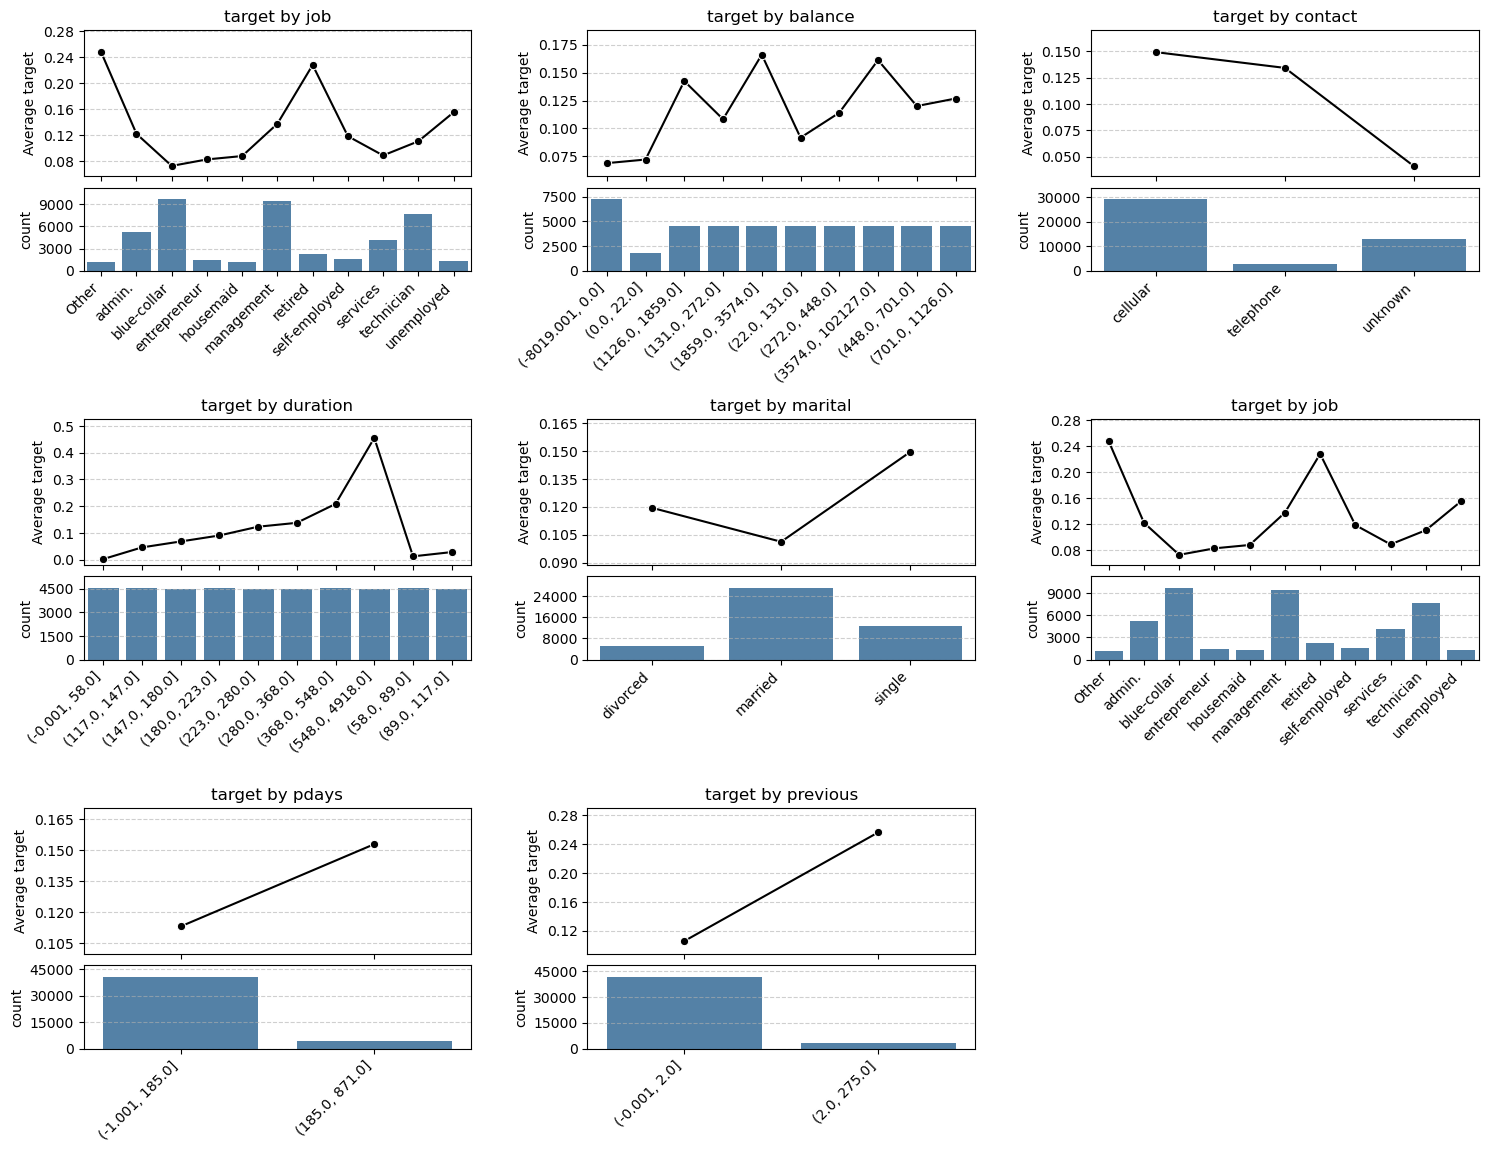

In [34]:
reload(f)
f.plot_target_vs_predictors(df, "target", predictors)

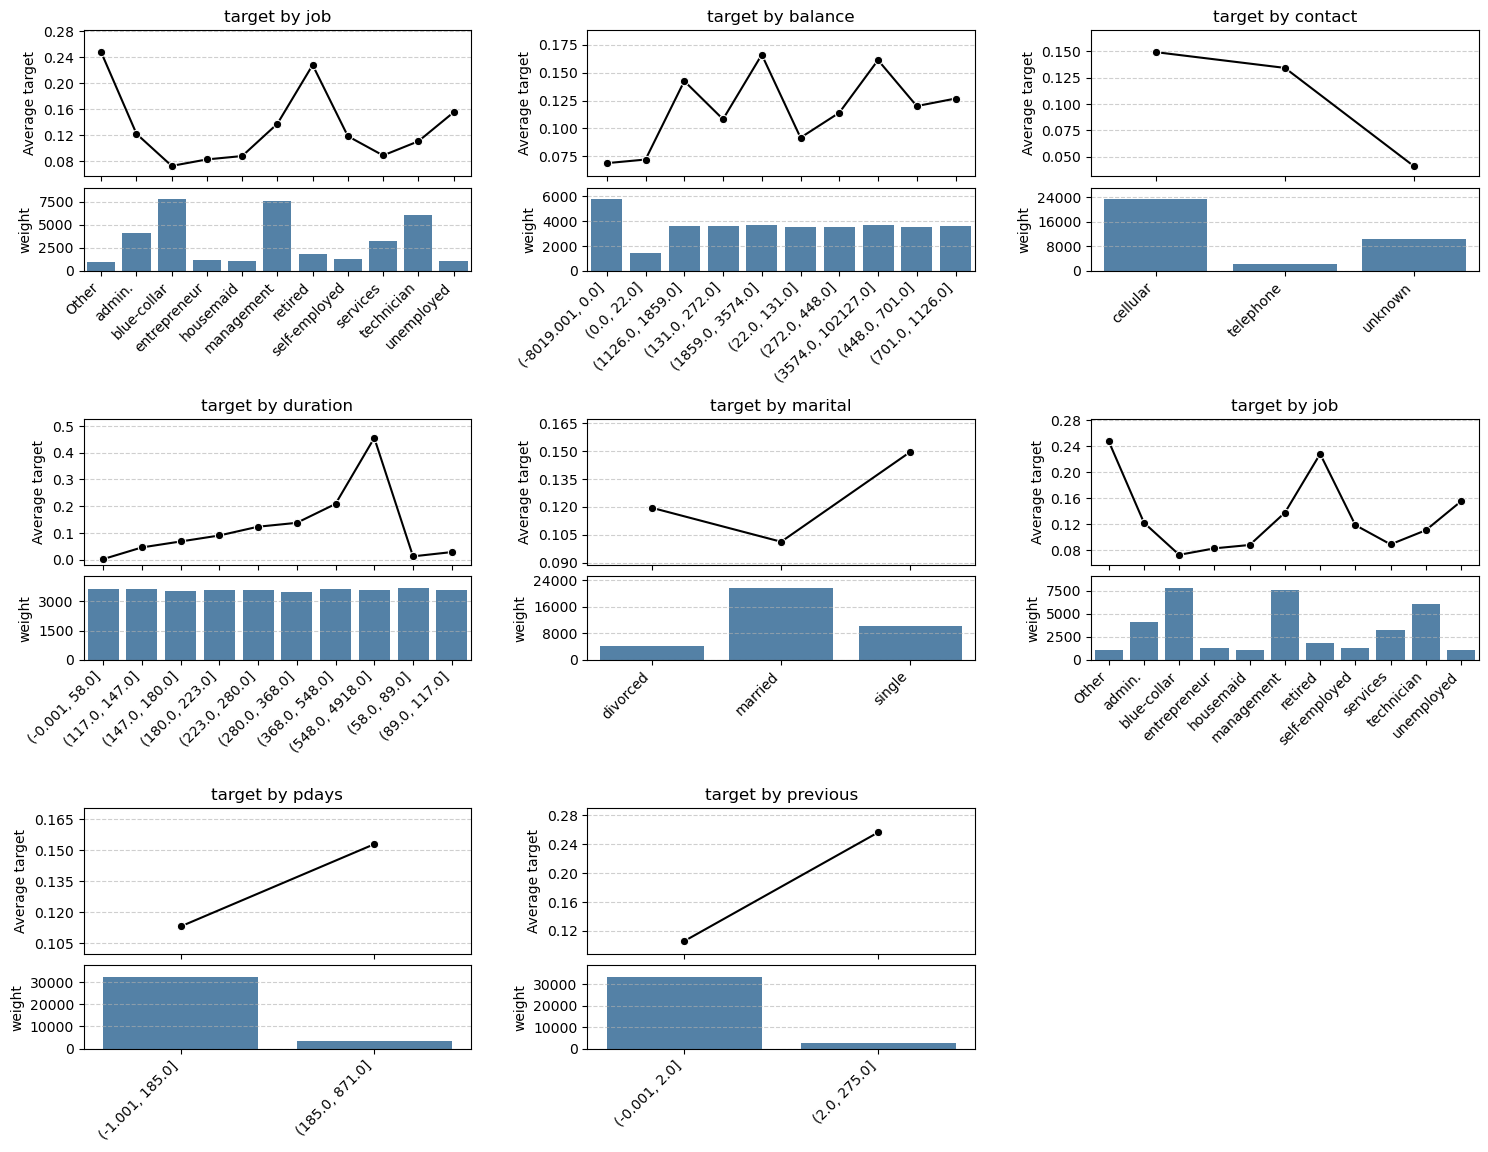

In [17]:
f.plot_target_vs_predictors(df, "target", predictors, weight_col="weights")

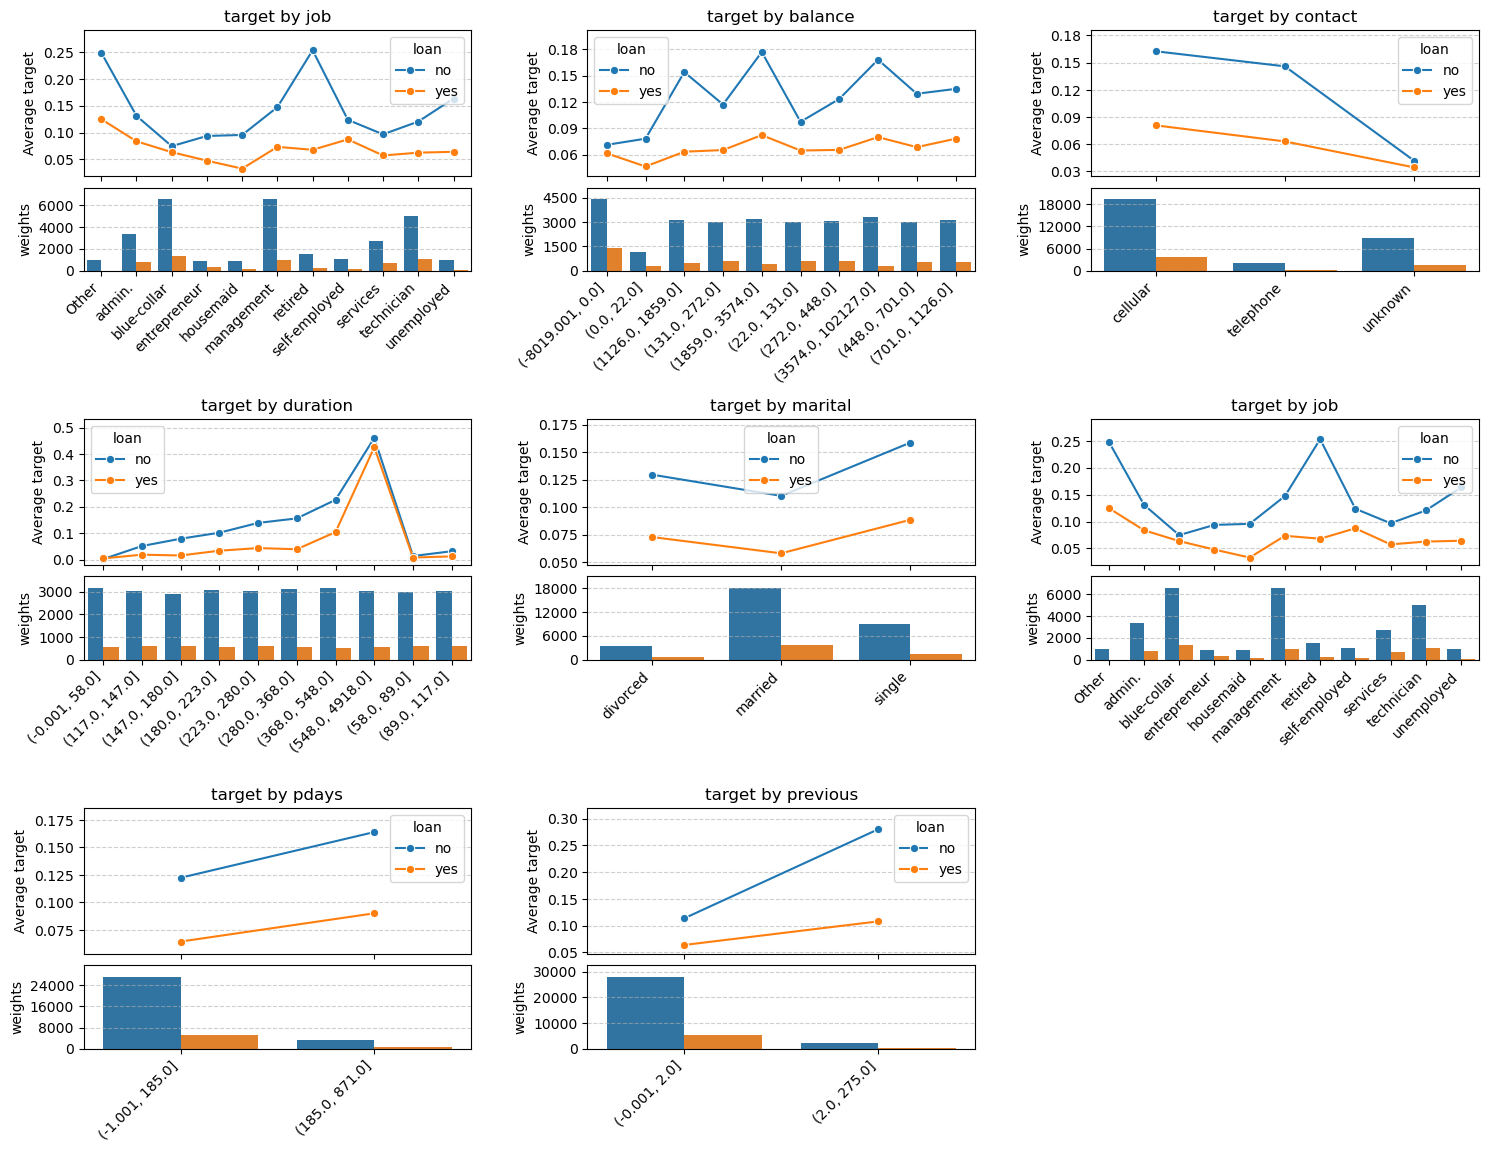

In [35]:
reload(f)
f.plot_target_vs_predictors(df, "target", predictors, group_col="loan", weight_col="weights")

## Error plots

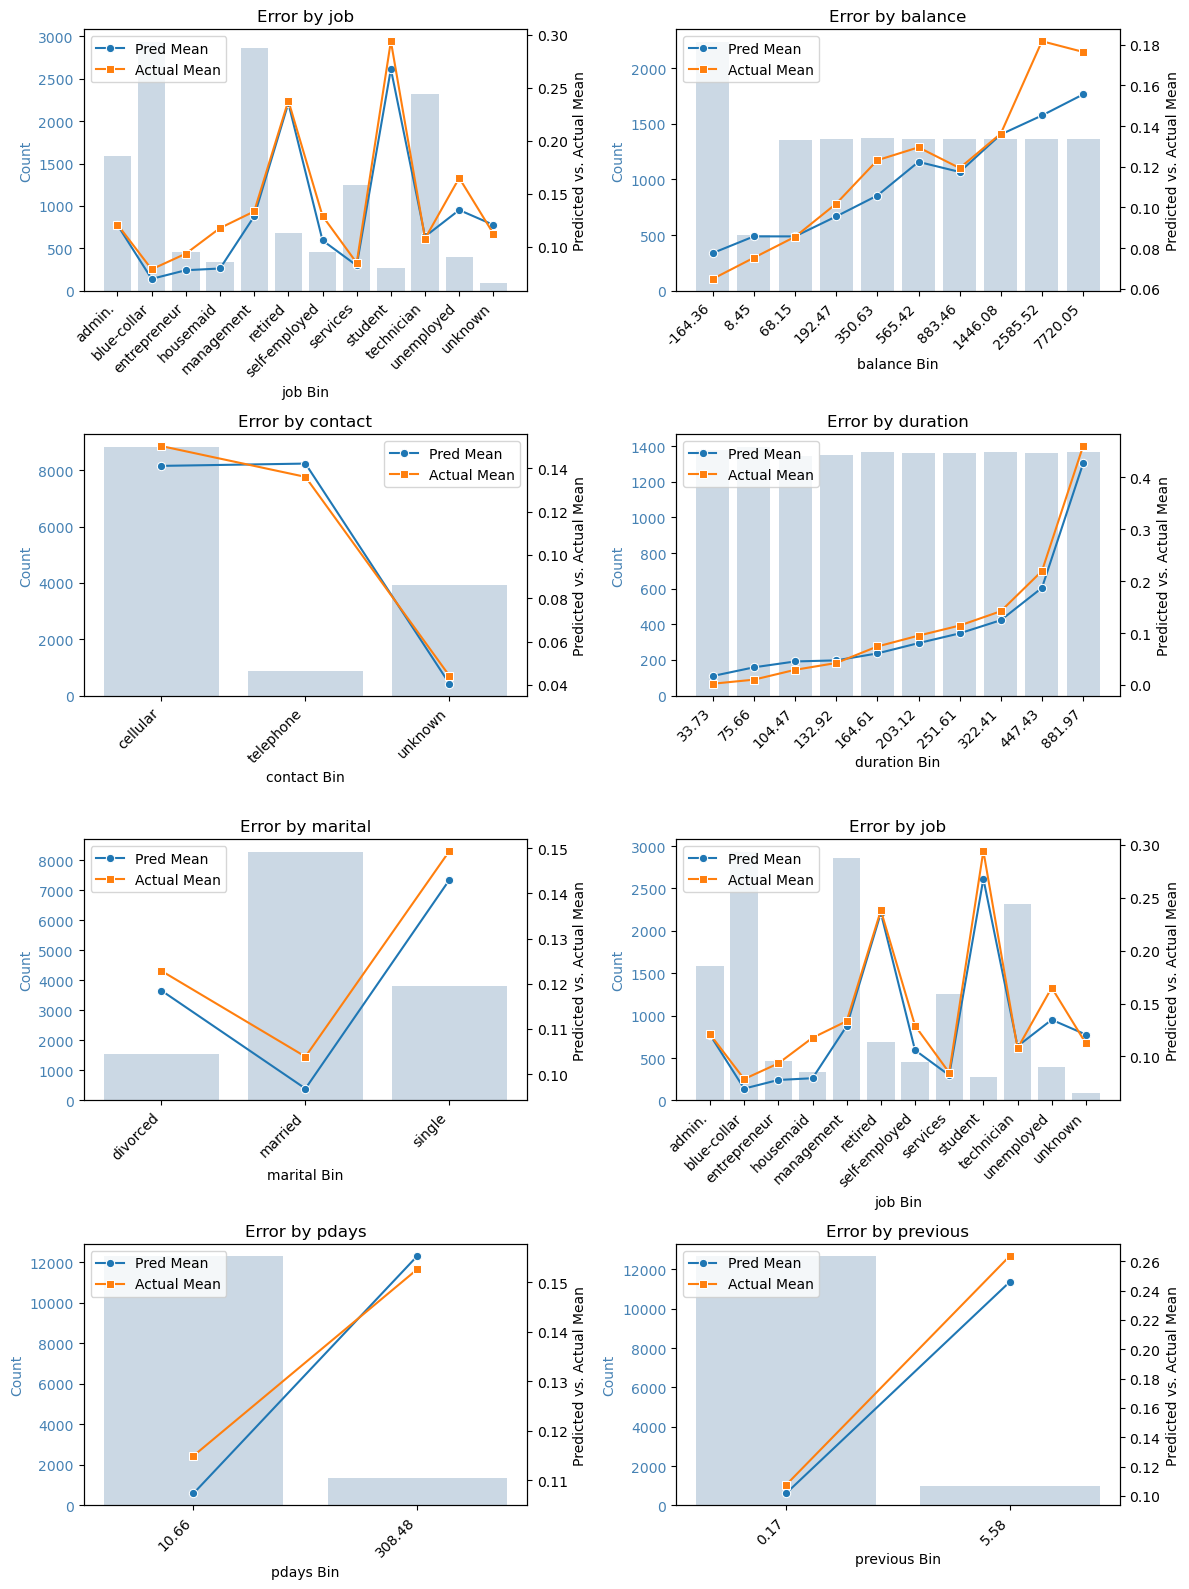

In [43]:
reload(f)
f.plot_error_by_group_grid(
    df.query("split == 'V'"), 
    "target", 
    "pred_glm", 
    predictors, 
    bins=10
    )

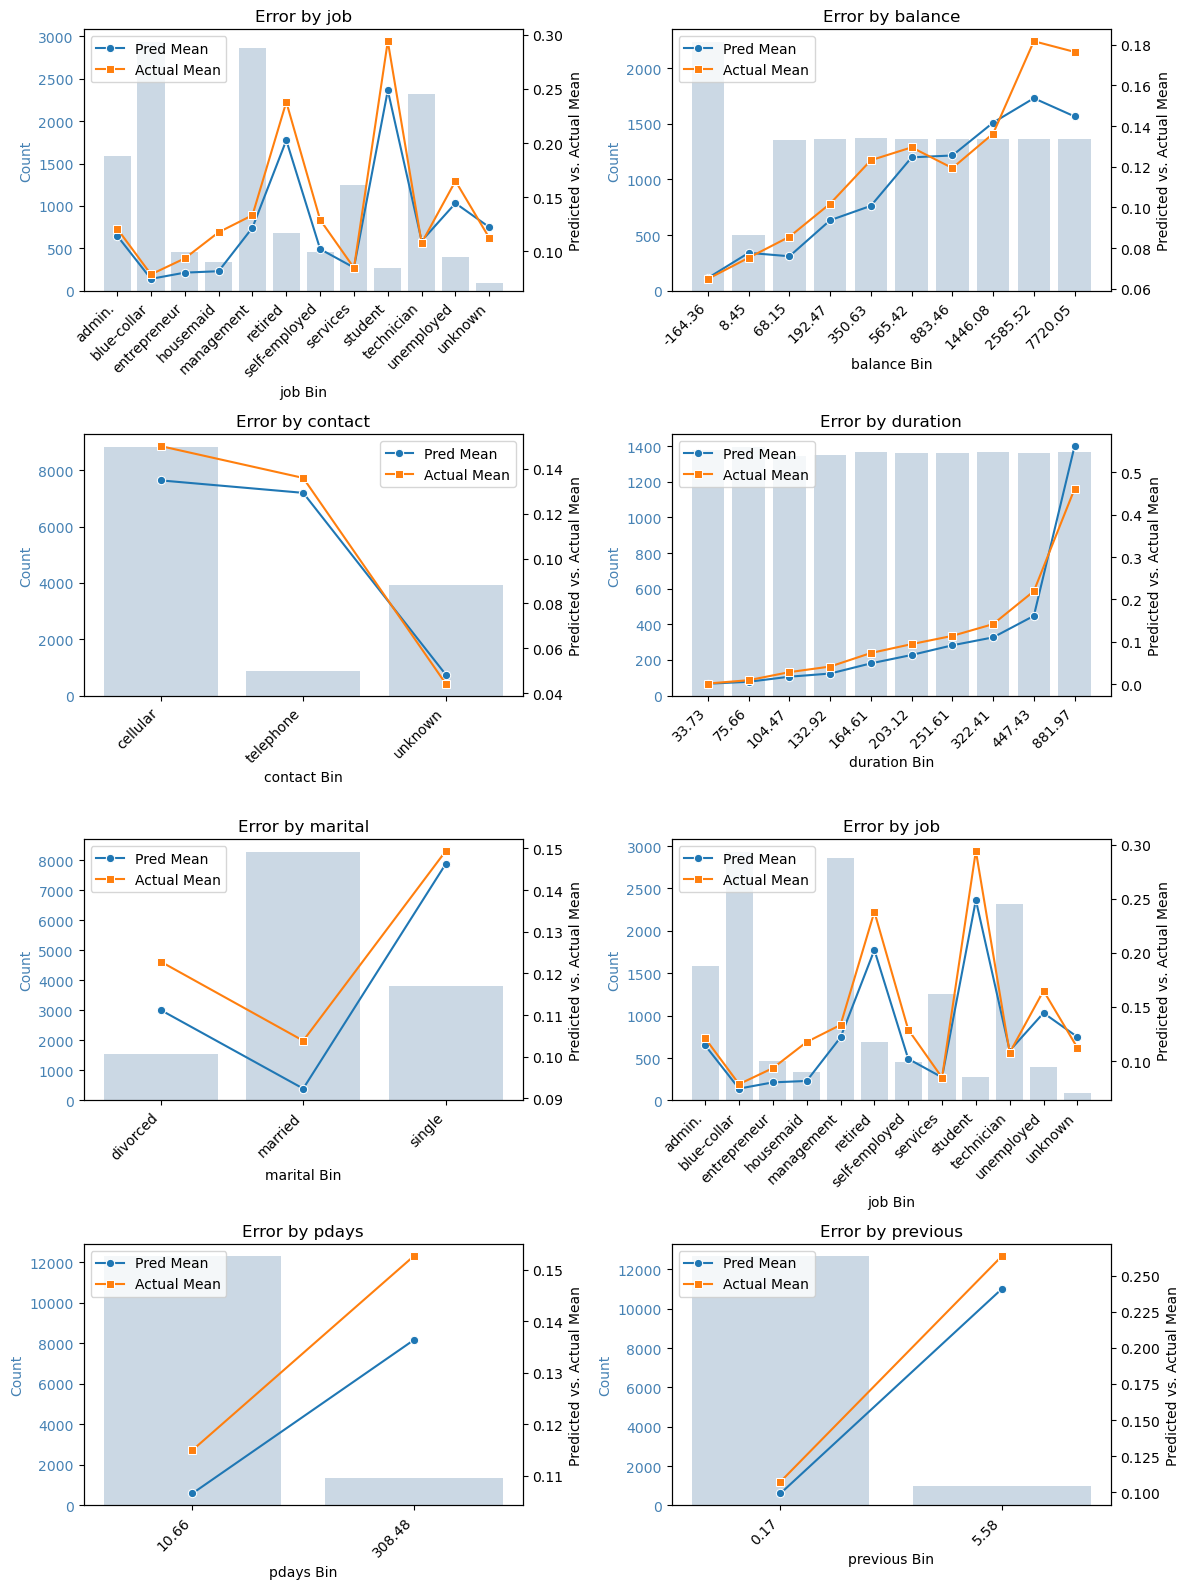

In [45]:
f.plot_error_by_group_grid(
    df.query("split == 'V'"), 
    "target", 
    "pred_xgb", 
    predictors, 
    bins=10
    )

## Explore creation of tabulation function and object

In [36]:
tabs = generate_and_save_tabulations(
    df=df,
    prediction_col="pred_glm",
    truth_col="target",
    group_vars=predictors,
    weights_col="weights",
    split_col="split",
    n_bins=10,
)


Tabulation report written to: tabulations.html
